<ipython-input-1-e3fe1ae2a06e>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  (output_array * 255).astype(np.uint8) for output_array in output_arrays


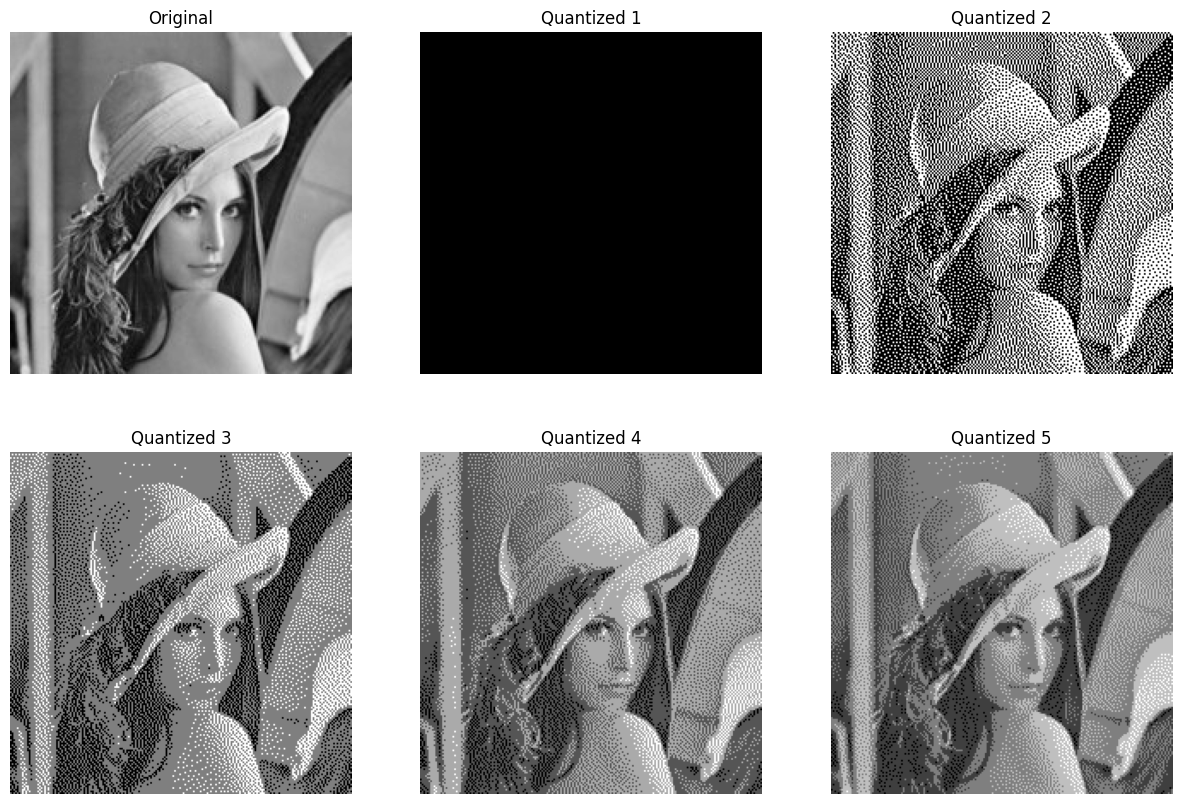

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def error_diffusion(image_file, levels):
    # Load the image
    img = Image.open(image_file)
    img = img.convert("L")  # convert to grayscale if it's not

    # Create the quantization levels
    quant_values_list = [np.linspace(0, 1, lvl) for lvl in range(1, levels + 1)]

    # Create an output array for each level
    img_arrays = [
        np.array(img, dtype=np.cfloat) / 255.0 for _ in range(levels)
    ]  # convert to float and normalize
    output_arrays = [np.zeros_like(img_array) for img_array in img_arrays]

    # Error diffusion
    for lvl in range(levels):
        for i in range(img_arrays[lvl].shape[0]):
            for j in range(img_arrays[lvl].shape[1]):
                original = img_arrays[lvl][i, j]
                closest_quant = find_nearest(quant_values_list[lvl], original)
                output_arrays[lvl][i, j] = closest_quant
                error = original - closest_quant
                if j + 1 < img_arrays[lvl].shape[1]:
                    img_arrays[lvl][i, j + 1] += error * 7 / 16
                if i + 1 < img_arrays[lvl].shape[0]:
                    img_arrays[lvl][i + 1, j - 1 if j > 0 else j] += error * 3 / 16
                    img_arrays[lvl][i + 1, j] += error * 5 / 16
                    if j + 1 < img_arrays[lvl].shape[1]:
                        img_arrays[lvl][i + 1, j + 1] += error * 1 / 16

    # Convert back to 8 bit and save
    output_images = [
        (output_array * 255).astype(np.uint8) for output_array in output_arrays
    ]
    output_images = [Image.fromarray(output_image) for output_image in output_images]

    # Save the images
    for idx, output_image in enumerate(output_images, start=1):
        output_image.save(f"output{idx}.png")

    # Display the images
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    for idx, output_image in enumerate(output_images, start=2):
        plt.subplot(2, 3, idx)
        plt.imshow(output_image, cmap="gray")
        plt.title(f"Quantized {idx-1}")
        plt.axis("off")

    plt.show()


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


# Run the function with the desired number of levels
error_diffusion("girl_grayscale.jpeg", 5)
